In this assignment you'll have to explore and classify time series. The dataset is [FordA](http://www.timeseriesclassification.com/description.php?Dataset=FordA), which is a set of recordings of engine noise under typical conditions and you need to classify if certain condition exists.

In [1]:
%pylab inline
plt.style.use("bmh")
plt.rcParams["figure.figsize"] = (6,6)

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Plotting improts
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm
import numpy as np

In [3]:
# Generic imports
import pathlib

# DS imports
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, roc_auc_score, roc_curve, classification_report

## Constants

In [4]:
DATA_DIR = pathlib.Path("data/")
DATASET = "FordA"

# Loading the data

Data files are stored in tabular format:

In [5]:
!head -n 2 C:\Users\yosefos\Desktop\YDATA\y_data_Itay_asaf_\Unsupervised_Learning\week_4\FordA

'head' is not recognized as an internal or external command,
operable program or batch file.


In [6]:
train = pd.read_csv("./FordA/FordA_TRAIN.txt",
                    header=None,
                    sep="\s+",
                    skipinitialspace=True)
test = pd.read_csv("./FordA/FordA_TEST.txt",
                   header=None,
                   sep="\s+",
                   skipinitialspace=True)

In [7]:
train.head()

0         1         2         3         4         5         6         7    \
0 -1.0 -0.797172 -0.664392 -0.373015  0.040815  0.526936  0.984288  1.353120   
1  1.0  0.804855  0.634629  0.373474  0.038343 -0.340988 -0.740860 -1.109667   
2 -1.0  0.727985  0.111284 -0.499124 -1.068629 -1.578351 -1.990534 -2.302031   
3 -1.0 -0.234439 -0.502157 -0.732488 -0.946128 -1.139739 -1.323336 -1.490243   
4 -1.0 -0.171328 -0.062285  0.235829  0.710396  1.239969  1.649823  1.876321   

        8         9    ...       491       492       493       494       495  \
0  1.578108  1.659251  ...  1.120756  0.722417  0.362068  0.092083 -0.081268   
1 -1.395357 -1.570192  ...  0.386403  0.049213 -0.258138 -0.510583 -0.683647   
2 -2.503403 -2.585211  ...  0.394463  0.463685  0.507735  0.517174  0.504588   
3 -1.607077 -1.620430  ... -0.952804 -0.929437 -0.922761 -0.929437 -0.909409   
4  1.865535  1.703751  ...  0.776188  0.725496  0.697453  0.731967  0.808545   

        496       497       498       499       500  
0 -0.212573 -0.391456 -0.664392 -1.073796 -1.564343  
1 -0.773817 -0.785255 -0.714885 -0.560443 -0.319086  
2  0.476270  0.438513  0.394463  0.339400  0.255391  
3 -0.835970 -0.695768 -0.478790 -0.188707  0.119736  
4  0.839823  0.733046  0.437520 -0.026585 -0.602213  

[5 rows x 501 columns]

So, each row represents a single measurement, with column `0` being class label, and columns `1-501` being measured values. Let's check missing values:

In [8]:
# ### IF ROW HAS THE SAME VALUE FOR ADJACENT COLUMNS THAN CLASSIFY AS -1
# y_pred = []
# df = test.diff(axis=1)
# for i, row in df.iterrows():
#     if (row == 0).any():
#         y_pred.append(-1)
#     else:
#         y_pred.append(1)

# print('Accuracy:',np.mean(y_pred==test["label"]))
# my_test = test["label"].to_numpy()
# indices_of_FP = []
# for i in range(len(y_pred)):
#     if (y_pred[i] == 1) & (my_test[i] == -1):
#         indices_of_FP.append(i)

# print("number of FP = {}".format( len(indices_of_FP)))

In [9]:
train.notnull().sum(axis=1).unique()

array([501], dtype=int64)

In [10]:
test.notnull().sum(axis=1).unique()

array([501], dtype=int64)

Let's change column names to something stdingful:

In [11]:
train.rename({0: "label"}, axis=1, inplace=True)
test.rename({0: "label"}, axis=1, inplace=True)

In [12]:
train.rename({cl: f"val_{cl}" for cl in range(1, 501)}, axis=1, inplace=True)
test.rename({cl: f"val_{cl}" for cl in range(1, 501)}, axis=1, inplace=True)

We can now select data values by filtering:

In [13]:
train.filter(like="val_")

val_1     val_2     val_3     val_4     val_5     val_6     val_7  \
0    -0.797172 -0.664392 -0.373015  0.040815  0.526936  0.984288  1.353120   
1     0.804855  0.634629  0.373474  0.038343 -0.340988 -0.740860 -1.109667   
2     0.727985  0.111284 -0.499124 -1.068629 -1.578351 -1.990534 -2.302031   
3    -0.234439 -0.502157 -0.732488 -0.946128 -1.139739 -1.323336 -1.490243   
4    -0.171328 -0.062285  0.235829  0.710396  1.239969  1.649823  1.876321   
...        ...       ...       ...       ...       ...       ...       ...   
3596  0.196022 -0.070102 -0.336226 -0.516799 -0.555282 -0.442793 -0.221369   
3597  0.041994  0.422255  0.740529  0.975426  1.109891  1.137270  1.058349   
3598 -0.570054 -0.333165 -0.293519 -0.425344 -0.590869 -0.615648 -0.348033   
3599  2.006732  2.079150  2.022036  1.867560  1.648112  1.379446  1.093717   
3600 -0.125241 -0.325363 -0.488237 -0.599045 -0.651111 -0.647106 -0.595040   

         val_8     val_9    val_10  ...   val_491   val_492   val_493  \
0     1.578108  1.659251  1.640809  ...  1.120756  0.722417  0.362068   
1    -1.395357 -1.570192 -1.619951  ...  0.386403  0.049213 -0.258138   
2    -2.503403 -2.585211 -2.550600  ...  0.394463  0.463685  0.507735   
3    -1.607077 -1.620430 -1.506933  ... -0.952804 -0.929437 -0.922761   
4     1.865535  1.703751  1.466467  ...  0.776188  0.725496  0.697453   
...        ...       ...       ...  ...       ...       ...       ...   
3596  0.025217  0.233320  0.350545  ...  1.715205  1.129082  0.528158   
3597  0.894955  0.671224  0.421544  ... -0.463329 -0.392667 -0.333749   
3598  0.275412  1.153586  2.035725  ...  0.902821  0.579700  0.157463   
3599  0.784057  0.434150  0.029284  ...  1.268671  1.148971  0.928088   
3600 -0.502922 -0.388109 -0.259946  ...  0.005352  0.157920  0.288753   

       val_494   val_495   val_496   val_497   val_498   val_499   val_500  
0     0.092083 -0.081268 -0.212573 -0.391456 -0.664392 -1.073796 -1.564343  
1    -0.510583 -0.683647 -0.773817 -0.785255 -0.714885 -0.560443 -0.319086  
2     0.517174  0.504588  0.476270  0.438513  0.394463  0.339400  0.255391  
3    -0.929437 -0.909409 -0.835970 -0.695768 -0.478790 -0.188707  0.119736  
4     0.731967  0.808545  0.839823  0.733046  0.437520 -0.026585 -0.602213  
...        ...       ...       ...       ...       ...       ...       ...  
3596 -0.039020 -0.573043 -1.061479 -1.514392 -1.934743 -2.316612 -2.603753  
3597 -0.316543 -0.340299 -0.392876 -0.450805 -0.482609 -0.467769 -0.393755  
3598 -0.353980 -0.885246 -1.314421 -1.512655 -1.393714 -0.942733 -0.270722  
3599  0.634953  0.311682 -0.007376 -0.270543 -0.432145 -0.441231 -0.280709  
3600  0.384876  0.451628  0.497019  0.527725  0.555761  0.574451  0.573116  

[3601 rows x 500 columns]

The dataset is almost balanced:

In [14]:
train.iloc[:, 0].value_counts()

-1.0    1846
 1.0    1755
Name: label, dtype: int64

In [15]:
test.iloc[:, 0].value_counts()

-1.0    681
 1.0    639
Name: label, dtype: int64

# Task 1: explore time series

In this task you need to plot data samples with class label designation. Consider 10 or 20 random samples, and create a `2 x 5` or `4 x 5` plot, with eash subplot being the data records (i. e. `train.filter(like="val_").iloc[<sample_idx>]`), subtitles displaying sample index and class label. You can use color as well.

In [16]:
N_SAMPLES = 10
N_COLS = 5
N_ROWS = N_SAMPLES // N_COLS

samples = train.sample(N_SAMPLES, replace=False)


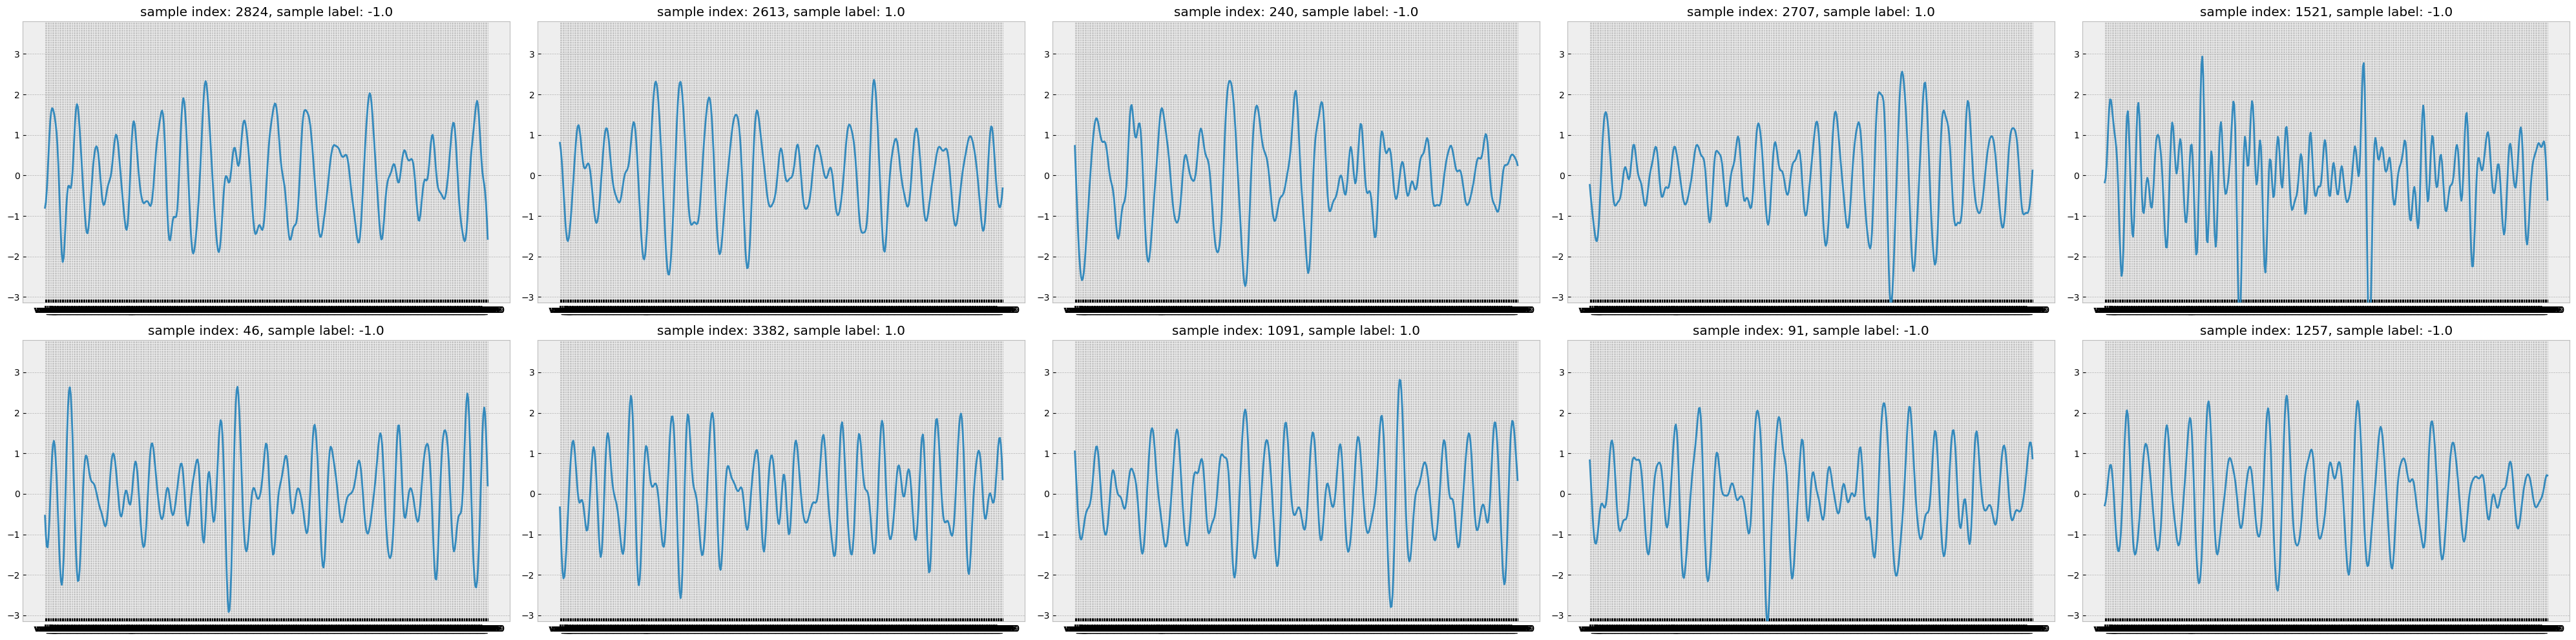

In [17]:
min_val = samples.min().min()
max_val = samples.max().max()
plt.figure( figsize=(20 * N_ROWS, 2 * N_COLS) )

for si, (sidx, sample) in enumerate(samples.iterrows()):
    plt.subplot(N_ROWS,N_COLS,si+1)
    plt.plot(train.filter(like="val_").iloc[si])
    plt.title("sample index: {}, sample label: {}".format(sidx,sample["label"]))
    plt.ylim(min_val,max_val)

plt.tight_layout();

it seems that the -1 class tends to reach the minimal or maximal value, meaning it creates louder noise.

# Task 2: explore statistics

In this task you need to plot simple statistics for each class, i. e. calculate `std`, `median`, `std` and other statistics (of your choice) for each row and then visualize them in such a way, that one can figure out if a distribution of a given statistics differs between class `1` and `-1`.

**Hint:** you can consider [violin plots](https://seaborn.pydata.org/examples/grouped_violinplots.html) or [scatter plot matrix](https://seaborn.pydata.org/examples/scatterplot_matrix.html) helpful.

## Example: median

In [18]:
train["data_median"] = train.filter(like="val_").median(axis=1)
test["data_median"] = test.filter(like="val_").median(axis=1)

The simplest visualization possible (you need to create smth more elaborated for other features altogether):

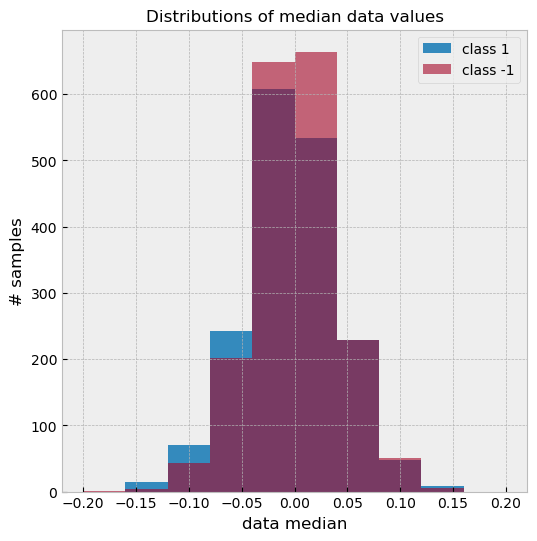

In [19]:
train.loc[train["label"]==1, "data_median"].plot(kind="hist",range=(-0.2, 0.2), label="class 1")
train.loc[train["label"]==-1, "data_median"].plot(kind="hist",range=(-0.2, 0.2), alpha=0.6, label="class -1")

plt.legend(loc=0)
plt.xlabel("data median")
plt.ylabel("# samples")
plt.title("Distributions of median data values", fontsize=12);

**Note:** we can easily check if median is a good feature with ROC curve and score (as they do not rely on any specific normalization of the "predicted" probabilities). Think on why we're using `-data_median`.

In [20]:
fpr, tpr, thr = roc_curve(train["label"], -train["data_median"])

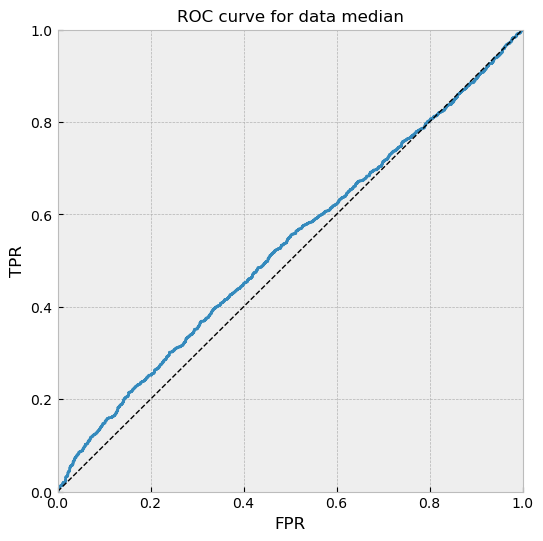

In [21]:
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], "--", c="k", linewidth=1)
plt.xlim(0, 1)
plt.ylim(0, 1)

plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC curve for data median", fontsize=12);

Ok, median contains *some* information (i. e. looking at median values is better than random classifier), but cannot serve as a *single* feature.

## Exploration

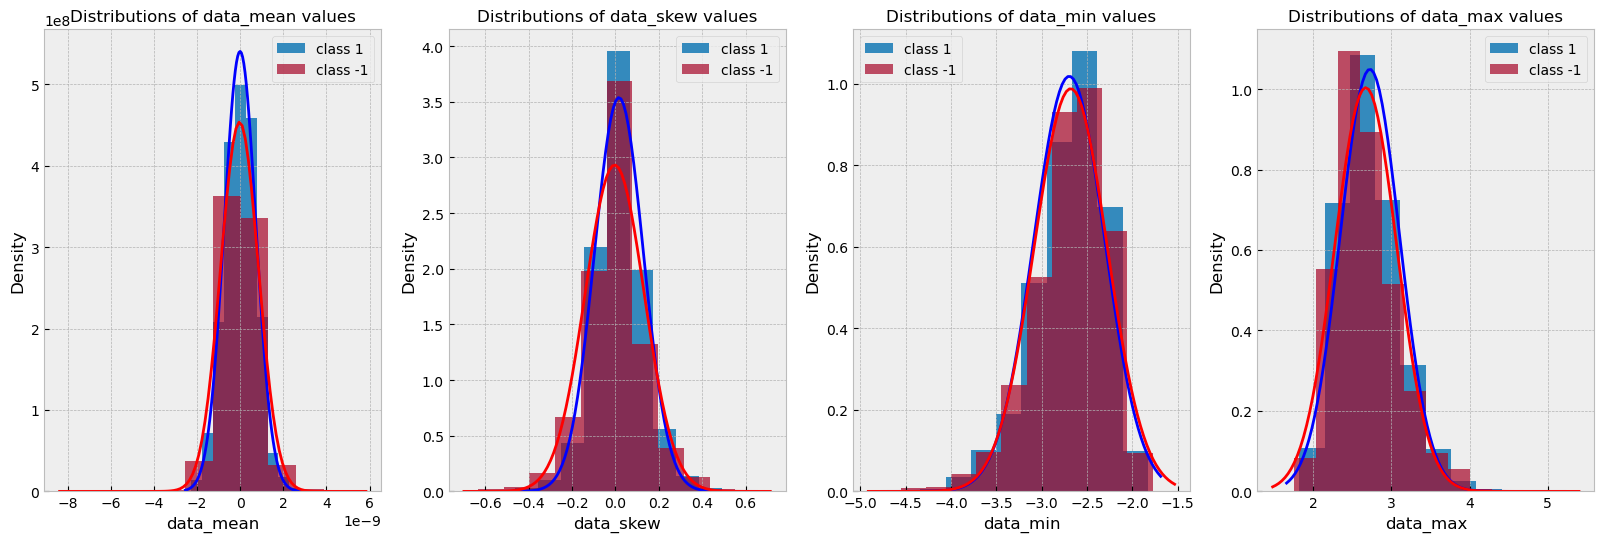

In [22]:
statistics = [pd.DataFrame.mean,pd.DataFrame.skew, min, max]
names = ['data_mean','data_skew','data_min','data_max']

plt.figure(figsize=(20,6))
for index, (statistic,name) in enumerate(zip(statistics,names)):
    
# Plot the histogram of the data with a density curve
    train[name] = train.filter(like="val_").apply(statistic,axis=1)
    plt.subplot(1,4,index+1)

    train.loc[train["label"]==1, name].plot(kind="hist", density=True, label="class 1")
    


    
    ## Overlay a bell curve on top of the histogram
    mu, std = train.loc[train["label"]==1, name].mean(), train.loc[train["label"]==1, name].std()
    xmin, xmax = plt.xlim()
    
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mu, std)
    plt.plot(x, p, linewidth=2,c='b')


# Plot the histogram of the data with a density curve
    train.loc[train["label"]==-1, name].plot(kind="hist",alpha=0.7, density=True, label="class -1")
    
    ## Overlay a bell curve on top of the histogram
    mu, std = train.loc[train["label"]==-1, name].mean(), train.loc[train["label"]==-1, name].std()
    xmin, xmax = plt.xlim()
    
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mu, std)
    plt.plot(x, p, linewidth=2,c='r')

    plt.legend(loc=0)
    plt.xlabel(name)
    plt.ylabel("Density")
    plt.title("Distributions of {} values".format(name), fontsize=12);

## ROC curves

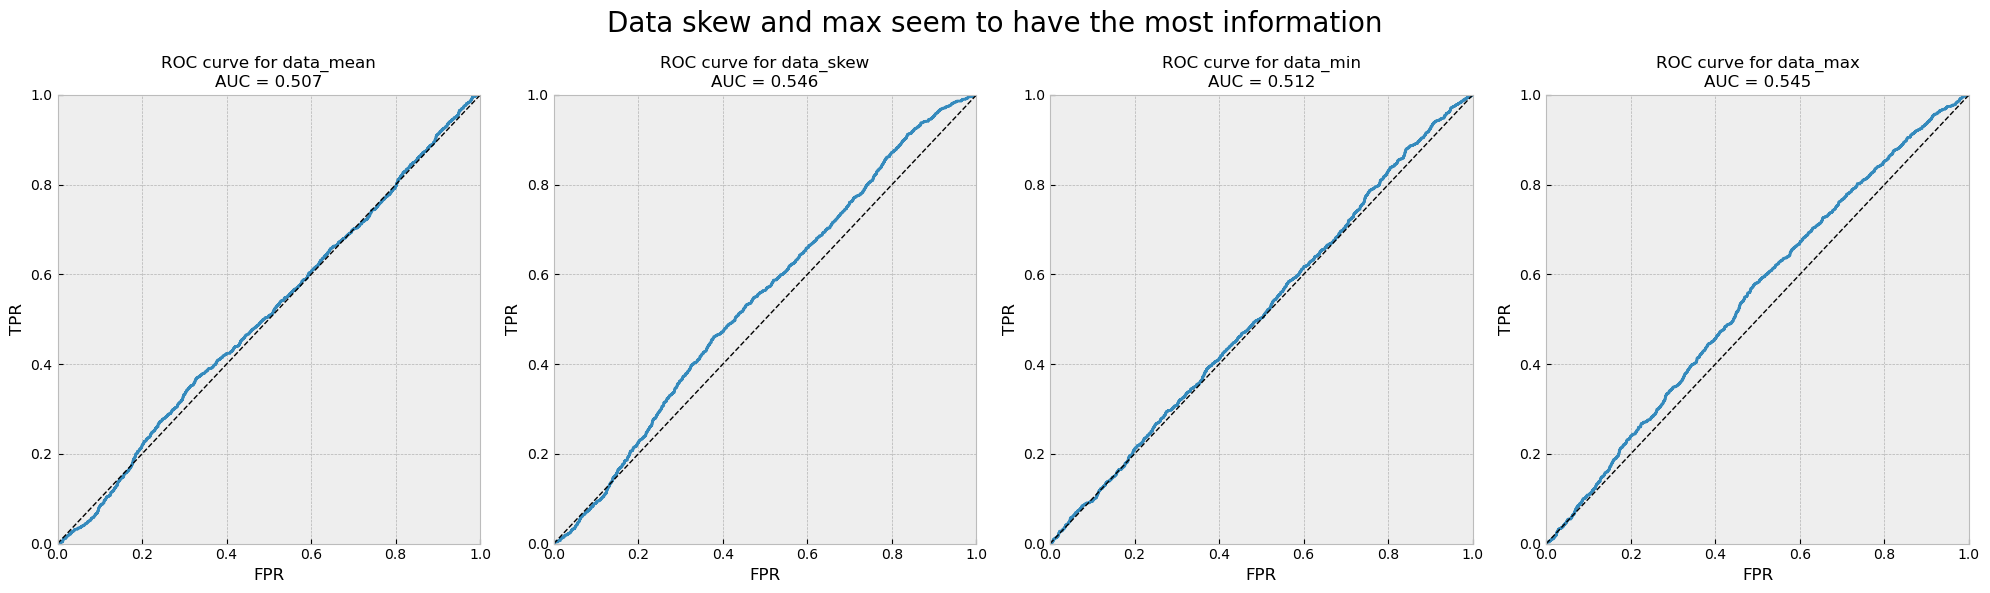

In [23]:
from sklearn.metrics import roc_auc_score
plt.figure(figsize=(20,6))

for index,name in enumerate(names):
    plt.subplot(1,4,index+1)
    if name == "data_min" :
        fpr, tpr, thr = roc_curve(train["label"], -train[name])
        auc = roc_auc_score(train["label"], -train[name])
    else:
        fpr, tpr, thr = roc_curve(train["label"], train[name])
        auc = roc_auc_score(train["label"], train[name])
        
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], "--", c="k", linewidth=1)
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    
  
    

   
    plt.title("ROC curve for {}\nAUC = {:0.3}".format(name,auc), fontsize=12);
plt.suptitle("Data skew and max seem to have the most information",fontsize=20)

plt.tight_layout()

# Min-Max scaling and Pairplotting data

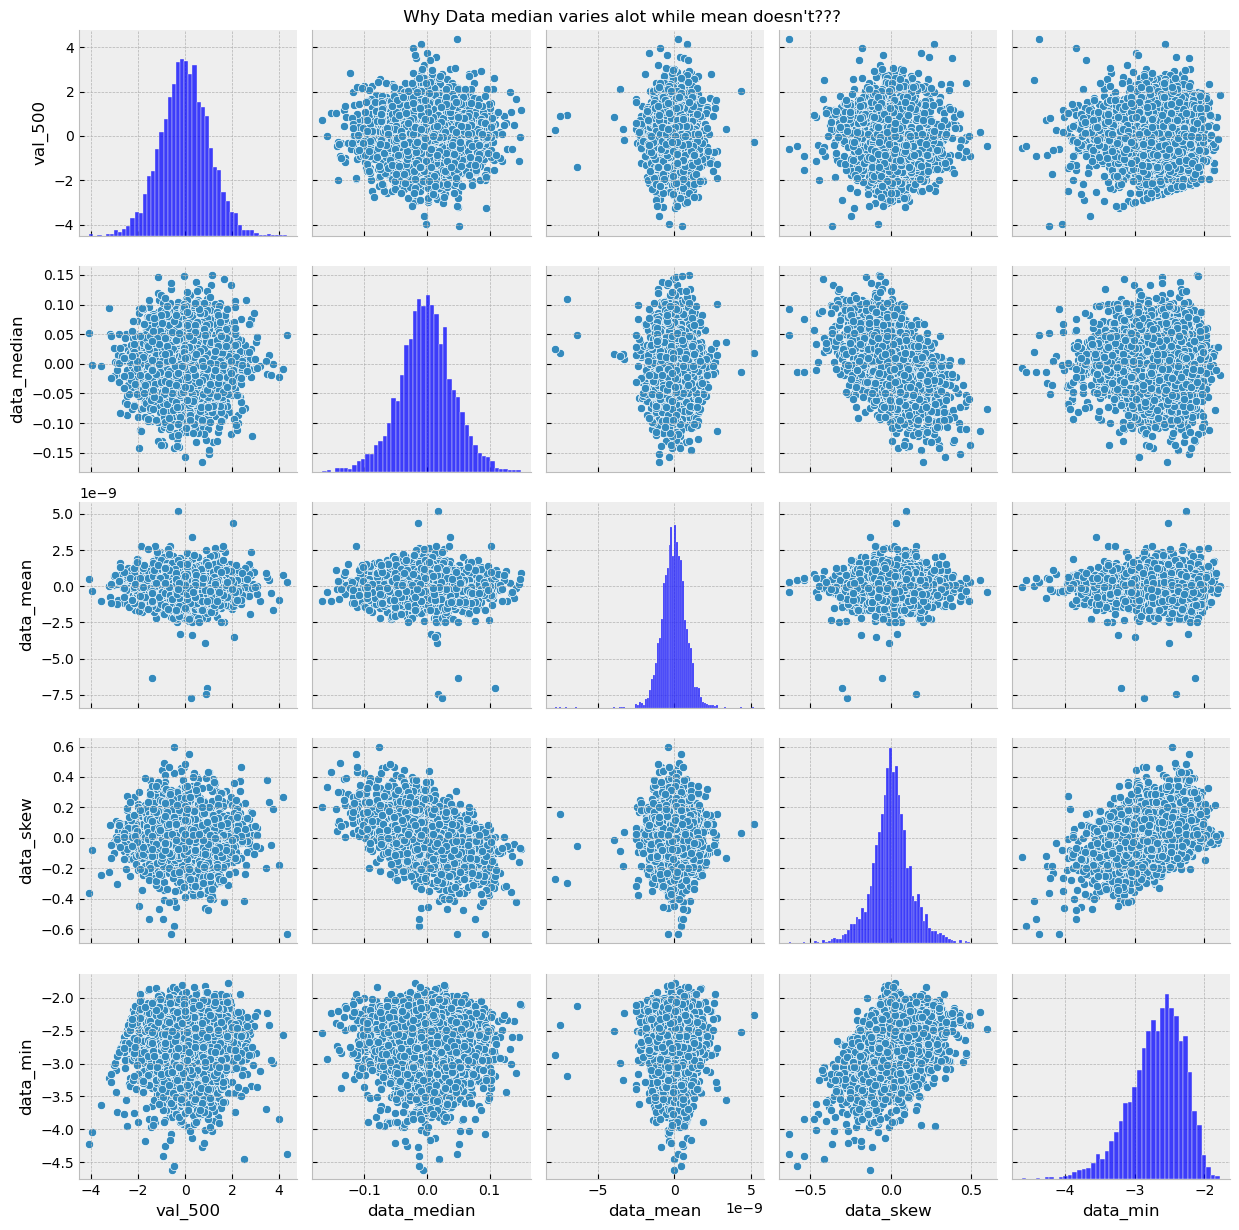

In [24]:
from sklearn.preprocessing import StandardScaler
# original data
data = train.iloc[:,-6:-1]

# Min-Max scaling
# scaler = StandardScaler()
# data.iloc[:,:] = scaler.fit_transform(data)
sns.pairplot(data);

plt.suptitle(" Why Data median varies alot while mean doesn't???")
plt.tight_layout()

## Pairplotting positive and negative 

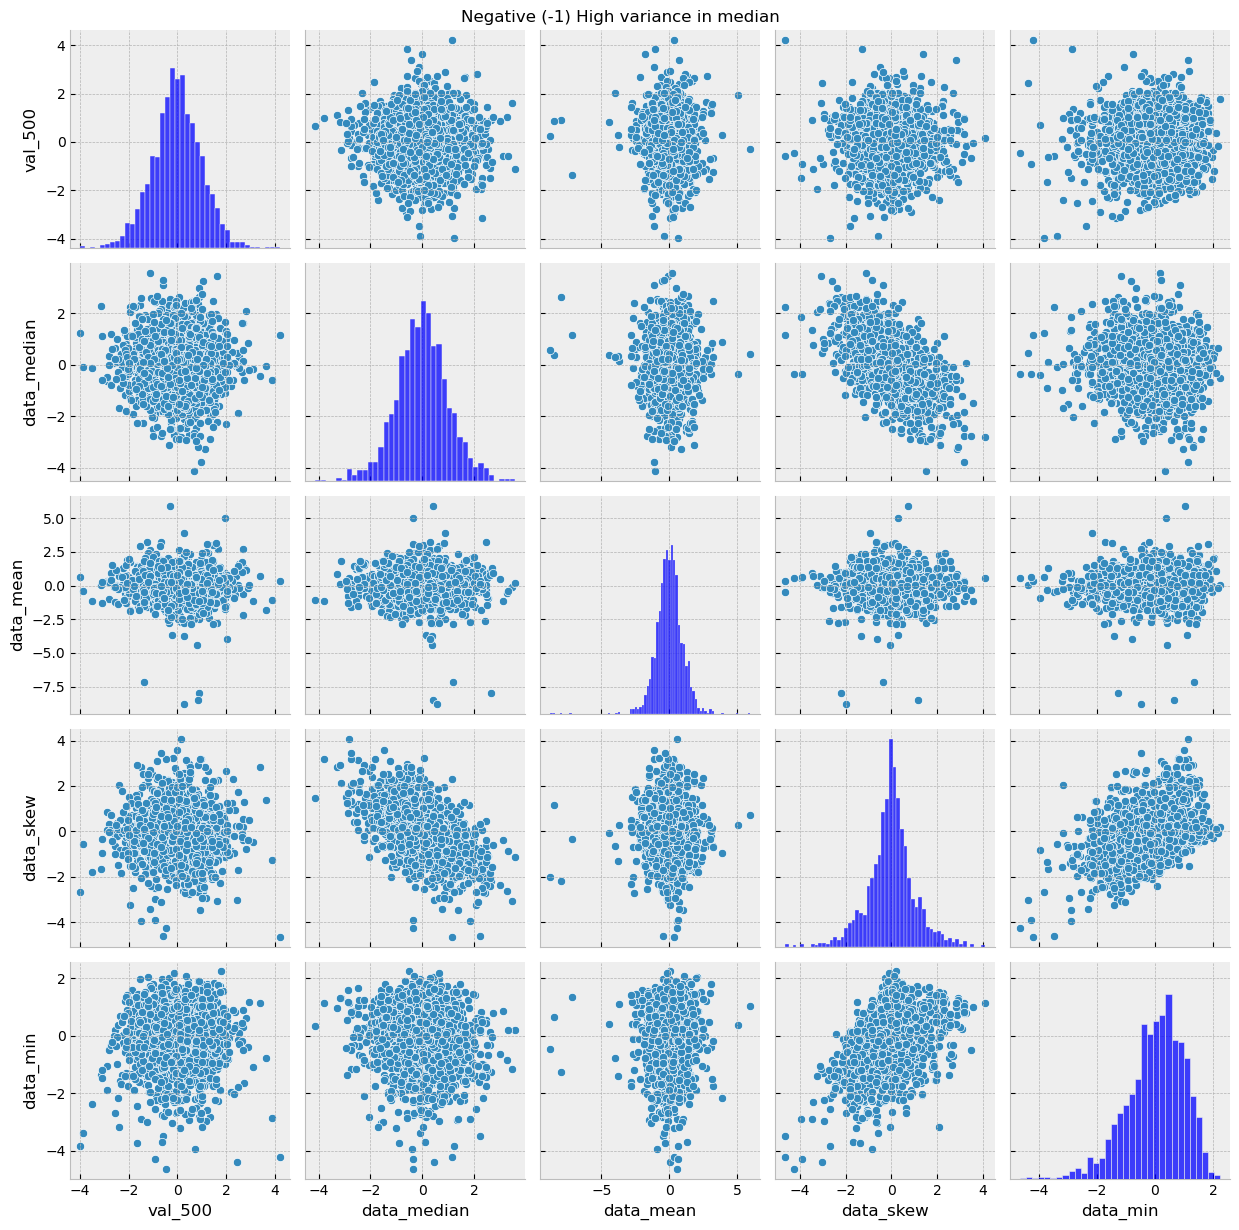

In [25]:

# original data
rows = train.index[train['label'] == -1]
data = train.iloc[rows,-6:-1]


scaler = StandardScaler()
data.iloc[:,:] = scaler.fit_transform(data)
sns.pairplot(data);

plt.suptitle("Negative (-1) High variance in median")
plt.tight_layout()

Positive

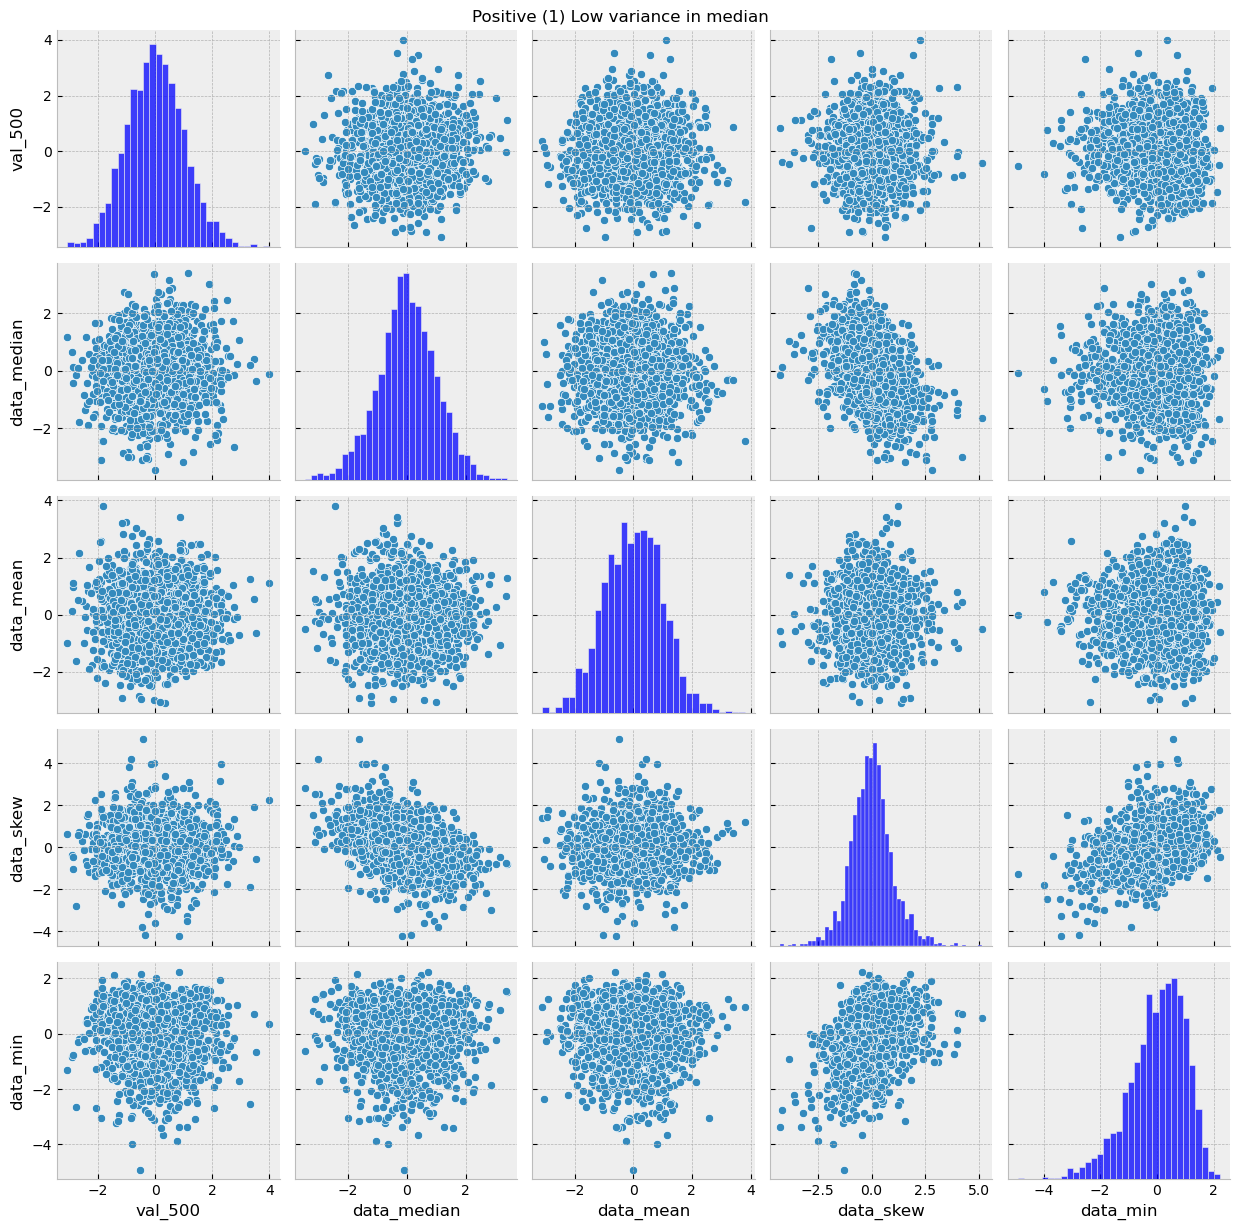

In [26]:

# original data
rows = train.index[train['label'] == 1]
data = train.iloc[rows,-6:-1]


scaler = StandardScaler()
data.iloc[:,:] = scaler.fit_transform(data)
sns.pairplot(data);
plt.suptitle("Positive (1) Low variance in median")
plt.tight_layout()

## Graphs above show that mean variation significantly differs between the classes

# Task 3: explore advanced features

In this task you need to calculate and analyze other time series features. looking on the data sample, think on which features in time/frequency domains may be useful for a classification of the dataset.

**Hint:** try various features from [`tsfresh`](https://tsfresh.readthedocs.io/en/latest/text/list_of_features.html).

## Example: 0-crossings

For this features we'll not use `tsfresh`, and will do some ninja stuff in Pandas itself:

**Step 1:** mask on `> 0`.

In [27]:
mask = (train.filter(like="val_") > 0).astype(int)
mask

val_1  val_2  val_3  val_4  val_5  val_6  val_7  val_8  val_9  val_10  \
0         0      0      0      1      1      1      1      1      1       1   
1         1      1      1      1      0      0      0      0      0       0   
2         1      1      0      0      0      0      0      0      0       0   
3         0      0      0      0      0      0      0      0      0       0   
4         0      0      1      1      1      1      1      1      1       1   
...     ...    ...    ...    ...    ...    ...    ...    ...    ...     ...   
3596      1      0      0      0      0      0      0      1      1       1   
3597      1      1      1      1      1      1      1      1      1       1   
3598      0      0      0      0      0      0      0      1      1       1   
3599      1      1      1      1      1      1      1      1      1       1   
3600      0      0      0      0      0      0      0      0      0       0   

      ...  val_491  val_492  val_493  val_494  val_495  val_496  val_497  \
0     ...        1        1        1        1        0        0        0   
1     ...        1        1        0        0        0        0        0   
2     ...        1        1        1        1        1        1        1   
3     ...        0        0        0        0        0        0        0   
4     ...        1        1        1        1        1        1        1   
...   ...      ...      ...      ...      ...      ...      ...      ...   
3596  ...        1        1        1        0        0        0        0   
3597  ...        0        0        0        0        0        0        0   
3598  ...        1        1        1        0        0        0        0   
3599  ...        1        1        1        1        1        0        0   
3600  ...        1        1        1        1        1        1        1   

      val_498  val_499  val_500  
0           0        0        0  
1           0        0        0  
2           1        1        1  
3           0        0        1  
4           1        0        0  
...       ...      ...      ...  
3596        0        0        0  
3597        0        0        0  
3598        0        0        0  
3599        0        0        0  
3600        1        1        1  

[3601 rows x 500 columns]

**Step 2:** calc `diff` to get crossings (from `< 0` to `> 0`, or other way around).

In [28]:
mask.diff(axis=1) == 1  # crossing from -0 to +0

val_1  val_2  val_3  val_4  val_5  val_6  val_7  val_8  val_9  val_10  \
0     False  False  False   True  False  False  False  False  False   False   
1     False  False  False  False  False  False  False  False  False   False   
2     False  False  False  False  False  False  False  False  False   False   
3     False  False  False  False  False  False  False  False  False   False   
4     False  False   True  False  False  False  False  False  False   False   
...     ...    ...    ...    ...    ...    ...    ...    ...    ...     ...   
3596  False  False  False  False  False  False  False   True  False   False   
3597  False  False  False  False  False  False  False  False  False   False   
3598  False  False  False  False  False  False  False   True  False   False   
3599  False  False  False  False  False  False  False  False  False   False   
3600  False  False  False  False  False  False  False  False  False   False   

      ...  val_491  val_492  val_493  val_494  val_495  val_496  val_497  \
0     ...    False    False    False    False    False    False    False   
1     ...    False    False    False    False    False    False    False   
2     ...    False    False    False    False    False    False    False   
3     ...    False    False    False    False    False    False    False   
4     ...    False    False    False    False    False    False    False   
...   ...      ...      ...      ...      ...      ...      ...      ...   
3596  ...    False    False    False    False    False    False    False   
3597  ...    False    False    False    False    False    False    False   
3598  ...    False    False    False    False    False    False    False   
3599  ...    False    False    False    False    False    False    False   
3600  ...     True    False    False    False    False    False    False   

      val_498  val_499  val_500  
0       False    False    False  
1       False    False    False  
2       False    False    False  
3       False    False     True  
4       False    False    False  
...       ...      ...      ...  
3596    False    False    False  
3597    False    False    False  
3598    False    False    False  
3599    False    False    False  
3600    False    False    False  

[3601 rows x 500 columns]

In [29]:
mask.diff(axis=1) == -1  # crossing from +0 to -0

val_1  val_2  val_3  val_4  val_5  val_6  val_7  val_8  val_9  val_10  \
0     False  False  False  False  False  False  False  False  False   False   
1     False  False  False  False   True  False  False  False  False   False   
2     False  False   True  False  False  False  False  False  False   False   
3     False  False  False  False  False  False  False  False  False   False   
4     False  False  False  False  False  False  False  False  False   False   
...     ...    ...    ...    ...    ...    ...    ...    ...    ...     ...   
3596  False   True  False  False  False  False  False  False  False   False   
3597  False  False  False  False  False  False  False  False  False   False   
3598  False  False  False  False  False  False  False  False  False   False   
3599  False  False  False  False  False  False  False  False  False   False   
3600  False  False  False  False  False  False  False  False  False   False   

      ...  val_491  val_492  val_493  val_494  val_495  val_496  val_497  \
0     ...    False    False    False    False     True    False    False   
1     ...    False    False     True    False    False    False    False   
2     ...    False    False    False    False    False    False    False   
3     ...    False    False    False    False    False    False    False   
4     ...    False    False    False    False    False    False    False   
...   ...      ...      ...      ...      ...      ...      ...      ...   
3596  ...    False    False    False     True    False    False    False   
3597  ...    False    False    False    False    False    False    False   
3598  ...    False    False    False     True    False    False    False   
3599  ...    False    False    False    False    False     True    False   
3600  ...    False    False    False    False    False    False    False   

      val_498  val_499  val_500  
0       False    False    False  
1       False    False    False  
2       False    False    False  
3       False    False    False  
4       False     True    False  
...       ...      ...      ...  
3596    False    False    False  
3597    False    False    False  
3598    False    False    False  
3599    False    False    False  
3600    False    False    False  

[3601 rows x 500 columns]

**Step 3:** calculate counts.

In [30]:
train["zero+"] = (mask.diff(axis=1) == 1).sum(axis=1)
train["zero-"] = (mask.diff(axis=1) == -1).sum(axis=1)

In [31]:
train["zero+"]

0       18
1       19
2       17
3       22
4       34
        ..
3596    21
3597    21
3598    32
3599    21
3600    20
Name: zero+, Length: 3601, dtype: int64

**Note:** we do not need to perform any normalization, as all samples have the same length.

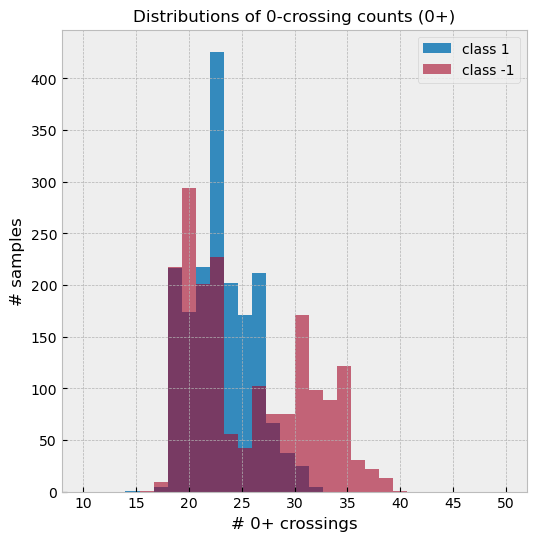

In [32]:
train.loc[train["label"]==1, "zero+"].plot(kind="hist", range=(10, 50),bins=30, label="class 1")
train.loc[train["label"]==-1, "zero+"].plot(kind="hist", range=(10, 50),bins=30, alpha=0.6, label="class -1")

plt.legend(loc=0)
plt.xlabel("# 0+ crossings")
plt.ylabel("# samples")
plt.title("Distributions of 0-crossing counts (0+)", fontsize=12);

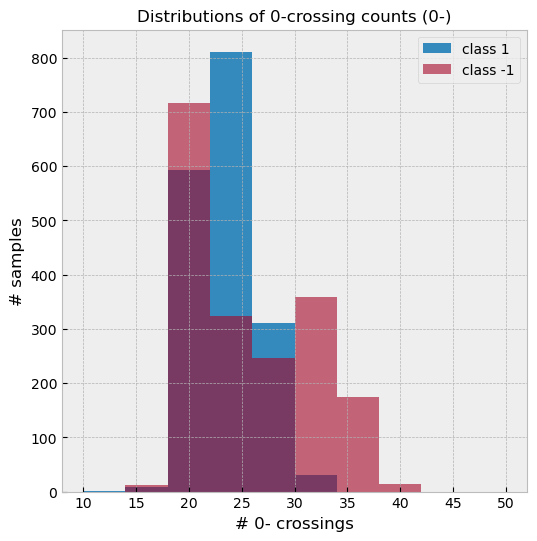

In [33]:
train.loc[train["label"]==1, "zero-"].plot(kind="hist", range=(10, 50), label="class 1")
train.loc[train["label"]==-1, "zero-"].plot(kind="hist", range=(10, 50), alpha=0.6, label="class -1")

plt.legend(loc=0)
plt.xlabel("# 0- crossings")
plt.ylabel("# samples")
plt.title("Distributions of 0-crossing counts (0-)", fontsize=12);

Of course, for oscillatory time series `zero+` and `zero-` are highly correlated, so we may drop one of them:

In [34]:
train.filter(like="zero").corr()

zero+     zero-
zero+  1.000000  0.988801
zero-  0.988801  1.000000

In [35]:
train.drop("zero-", axis=1, inplace=True)

The distribution of `zero+` looks fancy, and ROC curve reflects that:

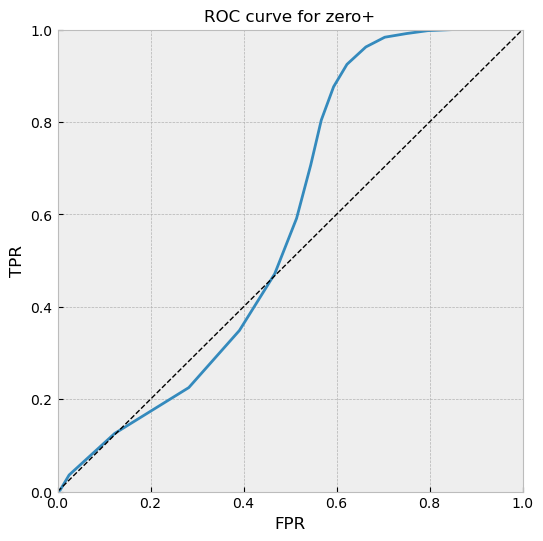

In [36]:
fpr, tpr, thr = roc_curve(train["label"], -train["zero+"])

plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], "--", c="k", linewidth=1)
plt.xlim(0, 1)
plt.ylim(0, 1)

plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC curve for zero+", fontsize=12);


Think on this in the following way.

Look at the histograms, and perform an estimate (no code, just in your head): given, that `zero+` is equal to `v`, what is the probability of a sample to belong to class `1`? Is this probability monotonic with `v`? How does this influence the choice of the model? Will logistic regression do the job here?

## Answer
The chance of belonging to class 1 is lowest at edge values of V, and highest at 22.5-30. this means the probability is not monotonic with V, therefor logistic regression will not be suitable as a model using only zero+ as a feature

## Exploration

In [37]:


# Attempting to seperate data on reccouring values

# plotting roc-auc of reccoruing values

# feeding decisionTree with tsfresh features extracted

## Plotting tsfresh


In [43]:
from tsfresh import extract_features
from tsfresh.feature_extraction import EfficientFCParameters
pd_for_ts = pd.melt(train.filter(like="val_").reset_index(),id_vars = 'index')
extract_features_arr = extract_features(pd_for_ts,column_id  = 'index',column_sort='variable',default_fc_parameters=EfficientFCParameters())







Feature Extraction: 100%|██████████| 50/50 [06:11<00:00,  7.44s/it]


In [44]:
extract_features_arr = extract_features_arr.dropna(axis=1)

In [45]:

from tsfresh.feature_selection.relevance import calculate_relevance_table
relevance_table = calculate_relevance_table(extract_features_arr, train.label)
relevance_table = relevance_table[relevance_table.relevant]
relevance_table.sort_values("p_value", inplace=True)
top_features = relevance_table[:5].feature.values # Take top 5 most relevant features

In [54]:
top_features = relevance_table[:5].feature.values # Take top 5 most relevant features

extract_features_arr['label'] = train['label']
top_features = np.append(top_features, 'label')
top_features

array(['value__percentage_of_reoccurring_values_to_all_values',
       'value__ar_coefficient__coeff_7__k_10',
       'value__percentage_of_reoccurring_datapoints_to_all_datapoints',
       'value__has_duplicate',
       'value__ratio_value_number_to_time_series_length', 'label'],
      dtype=object)

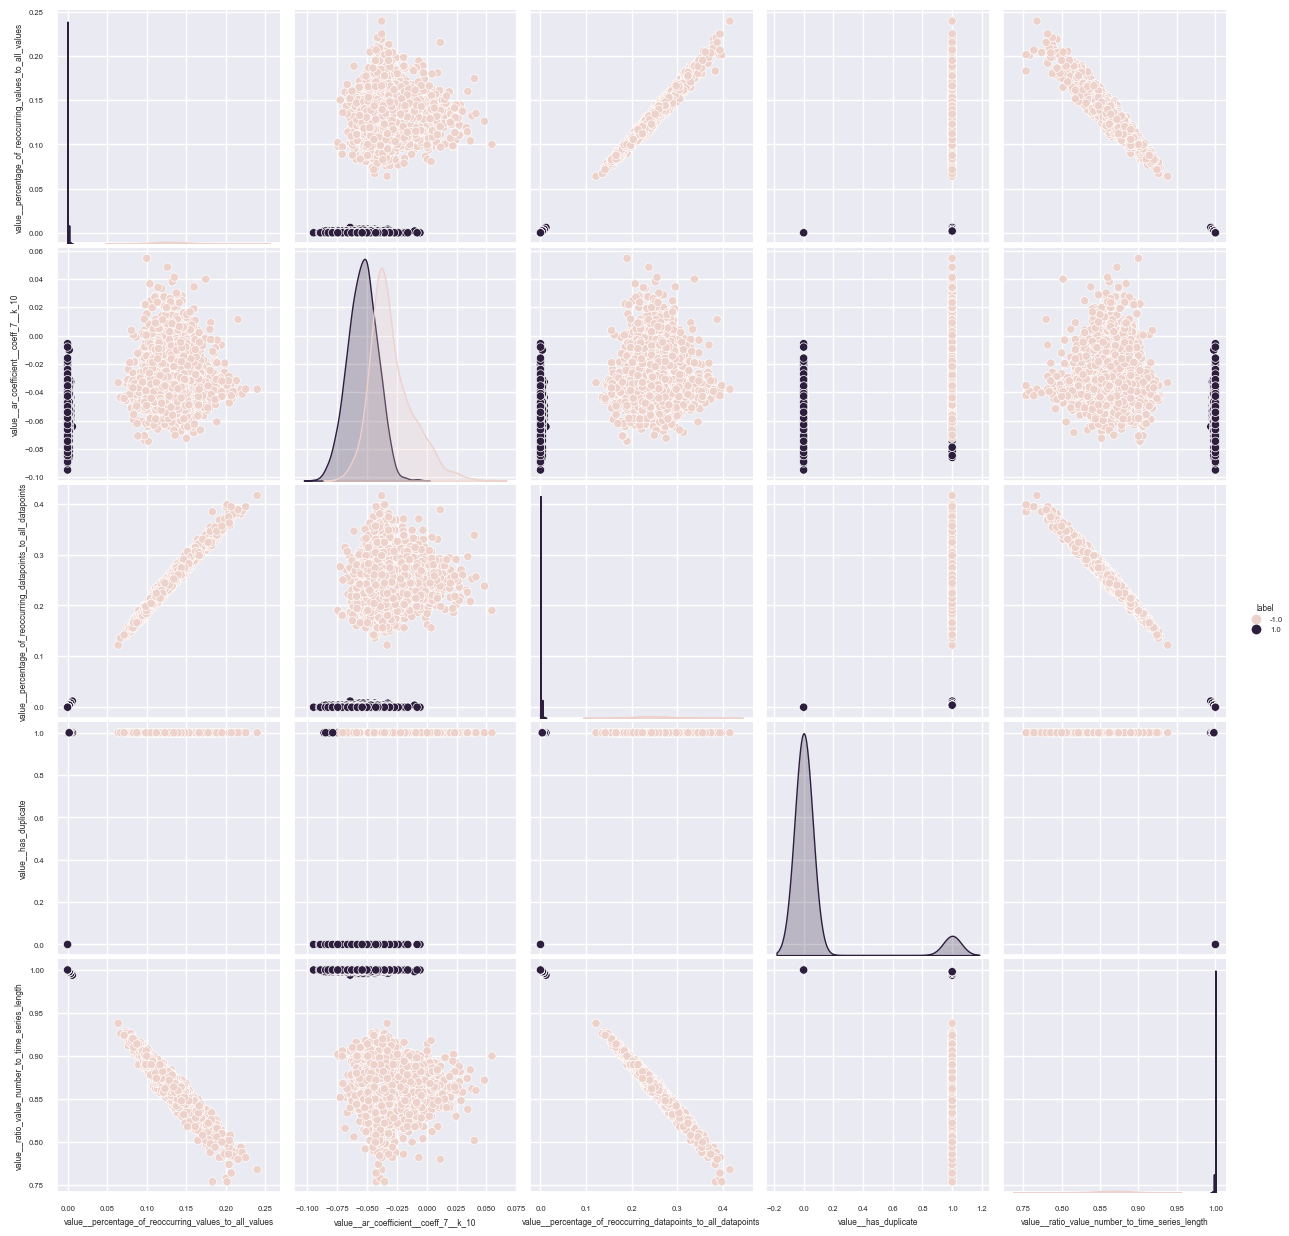

In [55]:



sns.set(font_scale=0.5)
sns.pairplot(extract_features_arr[top_features],hue='label');


In [59]:
top_features = top_features[:-1]
extract_features_arr.drop(columns=['label'],inplace=True);

#### We see from the tsfresh extracted features that reoccuring values may be useful for classifing the data (subplot row 1, col 4), lets explore further into that

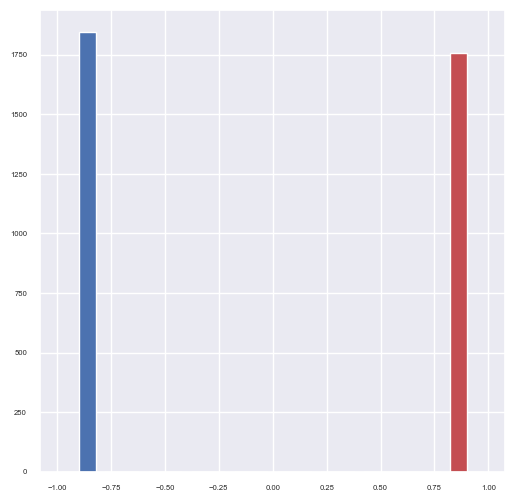

In [ ]:

# extract_features_arr['label'] = train['label']
first = extract_features_arr.loc[train['label'] == 1,top_features[0]]
second = extract_features_arr.loc[train['label'] == -1,top_features[0]]
plt.hist([first,second],label='label',color=['r','b']);

#### Exploring further, we try to see if a value reoccuring twice in a row is a useful feature
Meaning : Check if the samples in the dataset that have two consecutive equal values (neighboring columns) have a higher chance of belonging to class -1.

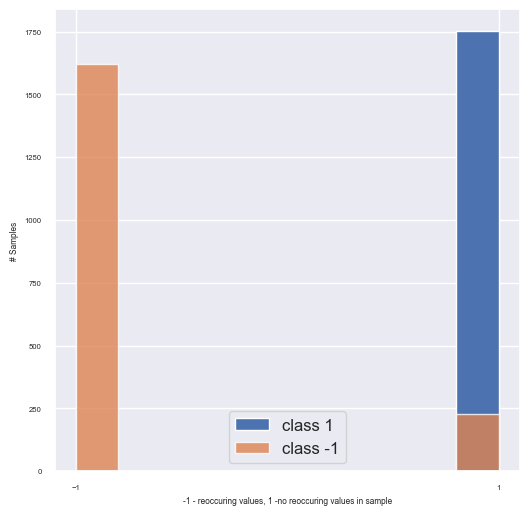

In [61]:
### IF ROW HAS THE SAME VALUE FOR ADJACENT COLUMNS THAN CLASSIFY AS -1  CLASSIFIER BASED ON RECCORUING VALUE
y_pred = []
df = train.diff(axis=1)
for i, row in df.iterrows():
    if (row == 0).any():
        y_pred.append(-1)
    else:
        y_pred.append(1)


train["reoccuring_value"] = y_pred
train.loc[train['label'] == 1,"reoccuring_value"].hist(label ='class 1',)
train.loc[train['label'] == -1,"reoccuring_value"].hist(alpha=0.8,label ='class -1')
plt.legend(fontsize=12)
plt.ylabel('# Samples')
plt.xlabel('-1 - reoccuring values, 1 -no reoccuring values in sample');
plt.xticks([-1,1]);


#### This seems to be a pretty good feature. Next we will check its roc:
Revealing its a good classifier

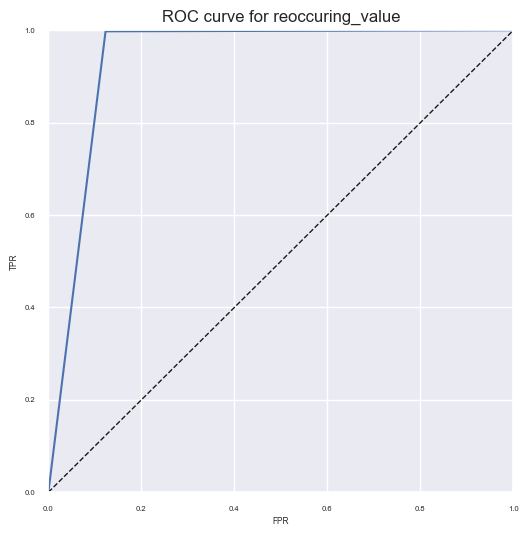

In [62]:
fpr, tpr, thr = roc_curve(train["label"], train["reoccuring_value"])

plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], "--", c="k", linewidth=1)
plt.xlim(0, 1)
plt.ylim(0, 1)

plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC curve for reoccuring_value", fontsize=12);


# Task 4: modeling

Given all the features you selected in Tasks 2 and 3, create a binary  classification model. You need to perform:

- reasonable train/validation split of `train`,
- select a model type (out of those, available in `sklearn`, no need to go for, say, gradient boosting),
- train a model, validate it and calculate the final score (ROC AUC) for the test set.

In [66]:
from sklearn.model_selection import train_test_split
X_train, X_validation, y_train, y_validation = train_test_split(extract_features_arr[top_features], train['label'], test_size=.2)

In [69]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)
print(classification_report(y_validation, clf.predict(X_validation)))

              precision    recall  f1-score   support

        -1.0       1.00      1.00      1.00       368
         1.0       1.00      1.00      1.00       353

    accuracy                           1.00       721
   macro avg       1.00      1.00      1.00       721
weighted avg       1.00      1.00      1.00       721



Lets do the test set.

In [70]:
from tsfresh import feature_extraction


To save time we will only extract from thest the top features

In [81]:
test_for_ts = pd.melt(test.filter(like="val_").reset_index(),id_vars = 'index')

In [82]:
test_extracted_features = extract_features(test_for_ts,column_id  = 'index',column_sort='variable',default_fc_parameters=EfficientFCParameters())

Feature Extraction: 100%|██████████| 49/49 [00:17<00:00,  2.84it/s]


Lets predict


In [83]:
test_extracted_features

value__variance_larger_than_standard_deviation  \
0                                                0.0   
1                                                0.0   
2                                                0.0   
3                                                0.0   
4                                                0.0   
...                                              ...   
1315                                             0.0   
1316                                             0.0   
1317                                             0.0   
1318                                             0.0   
1319                                             0.0   

      value__has_duplicate_max  value__has_duplicate_min  \
0                          0.0                       0.0   
1                          0.0                       0.0   
2                          0.0                       0.0   
3                          0.0                       0.0   
4                          0.0                       0.0   
...                        ...                       ...   
1315                       0.0                       0.0   
1316                       0.0                       0.0   
1317                       0.0                       0.0   
1318                       0.0                       0.0   
1319                       0.0                       0.0   

      value__has_duplicate  value__sum_values  value__abs_energy  \
0                      1.0       2.783100e-07         499.000002   
1                      1.0       6.134000e-07         499.000000   
2                      1.0      -1.045000e-07         498.999998   
3                      0.0       1.563000e-07         499.000001   
4                      1.0      -3.645000e-07         499.000002   
...                    ...                ...                ...   
1315                   1.0       9.555000e-07         498.999998   
1316                   0.0      -2.699999e-09         499.000001   
1317                   0.0      -3.726400e-07         499.000002   
1318                   0.0      -6.159000e-07         499.000000   
1319                   0.0       3.137000e-07         499.000001   

      value__mean_abs_change  value__mean_change  \
0                   0.495809           -0.001470   
1                   0.499854           -0.001456   
2                   0.318919           -0.001311   
3                   0.400846           -0.003377   
4                   0.352412            0.003132   
...                      ...                 ...   
1315                0.554846           -0.001024   
1316                0.444936            0.002131   
1317                0.434927           -0.002023   
1318                0.354949           -0.001392   
1319                0.408688            0.000089   

      value__mean_second_derivative_central  value__median  ...  \
0                                 -0.000142      -0.001575  ...   
1                                 -0.000598       0.039186  ...   
2                                  0.000880       0.015263  ...   
3                                  0.001730      -0.016963  ...   
4                                 -0.001143       0.046735  ...   
...                                     ...            ...  ...   
1315                              -0.000046      -0.034776  ...   
1316                               0.000171      -0.059453  ...   
1317                              -0.000465      -0.018789  ...   
1318                               0.000148       0.012554  ...   
1319                              -0.002520       0.087032  ...   

      value__fourier_entropy__bins_5  value__fourier_entropy__bins_10  \
0                           0.484652                         0.705932   
1                           0.424518                         0.689876   
2                           0.204871                         0.215617   
3                           0.300965                         0.427395   


In [87]:
clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)
print(classification_report(test['label'], clf.predict(test_extracted_features[top_features])))

              precision    recall  f1-score   support

        -1.0       1.00      1.00      1.00       681
         1.0       1.00      1.00      1.00       639

    accuracy                           1.00      1320
   macro avg       1.00      1.00      1.00      1320
weighted avg       1.00      1.00      1.00      1320

